# GtSt: Multiple Testing and Variable Selection along Least Angle Regression's path

This notebook presents the numerical experiments of the paper entitled 

> *Multiple Testing and Variable Selection along Least Angle Regression's path*, [arXiv:1906.12072v3](https://arxiv.org/abs/1906.12072v3).

We present the following points:
- A comparison of the **power and FDR control** on simulated data for **GtST, FCD and Knockoff** in **Section I**;
- Presentation of **HIV dataset** in **Section II**;
- A comparison of the **power and FDR control on HIV dataset** for **GtST, FCD, Knockoff and Slope** in **Section III**;
- A **new formulation of LARS algorithm** in **Section IV**;

The methods considered are:
- **[Knockoff+]** Knockoff+ filters for FDR control and we use the implementation presented on the webpage <https://web.stanford.edu/group/candes/knockoffs/> based on the paper:
> *Controlling the False Discovery Rate via Knockoffs*, [arXiv:1404.5609](https://arxiv.org/abs/1404.5609);
- **[FCD]** False Discovery Control via Debiasing and we use the implementation of debiased lasso presented on the webpage <https://web.stanford.edu/~montanar/sslasso/> with the theoretical value $\bar\lambda=2\sqrt{(2\log p)/n}$ for the regularizing parameter. When the sample size is larger than the number of predictors ($n\geq p$), the debiasing step in FCD is superfluous as the decorrelating matrix ($M$) can be the inverse of the sample covariance. So, in this case, we start with an unbiased estimator upfront (which is Ordinary Least Squares OLS). The FCD then becomes  **[t-OLS]**, thresholding the test statistics $|T_i|$ obtained from OLS. We use the implementation presented in the paper:
> *False Discovery Rate Control via Debiased Lasso*, [arXiv:1803.04464](https://arxiv.org/abs/1803.04464);
- **[Slope]** Slope for FDR control, as presented in the paper:
> *SLOPE - Adaptive variable selection via convex optimization* [arXiv:1407.3824](https://arxiv.org/abs/1407.3824);
- **[GtSt-BH]** Generalized t-Spacing tests on successive entries of the LARS path comibined with a Benjamini–Hochberg procedure based on the sequence of spacings $\hat  \beta_{012},\hat  \beta_{123},\ldots,\hat  \beta_{a(a+1)(a+2)},\ldots$ with nominal value $\alpha= 0.1$ and presented in the paper:
> *Multiple Testing and Variable Selection along Least Angle Regression's path*, [arXiv:1906.12072v3](https://arxiv.org/abs/1906.12072v3).

We load the following packages for this notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from lars.multiple_spacing_tests import generate_data
from lars.LARS import LARS
from lars.FDR import Testing
from lars.FCD import FCD
from sklearn import linear_model
import scipy as sc
import cvxpy as cp
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

## I. FDR and power on simulated data

We take the experiments introduced in Section 5 of the paper:
> *False Discovery Rate Control via Debiased Lasso*, [arXiv:1803.04464](https://arxiv.org/abs/1803.04464);

As in this reference, we consider the linear model with a design $X$ with independent rows draw with respect to $\mathcal N_p(0,\Sigma)$. The covariance $\Sigma\in\mathbb R^{p\times p}$ is such that $\Sigma_{ij} = r^{|i-j|}$, for some parameter $r\in(0,1)$. We then normalize the columns of $X$ to have unit Euclidean norm. We draw a $s_0$-sparse vector $\beta^0\in \mathbb R^p$ by choosing a support of size $s_0$ at random with values $\{\pm A\}$ uniformly at random, where $A>0$ denotes the absolute value of the amplitudes. The Gaussian noise term $\eta$ is drawn from $\mathcal N_n(0,\mathrm{Id}_{n\times n})$. 

### Ia. Effect of signal amplitude

We choose $n = 100$, $p = 200$, $k = 20$, $\eta = 0.1$ and vary the signal amplitude in the set $A\in [25]$. We compute the FDR and power by averaging across `nbite = 3000` realizations of noise and the generation of coefficient vector $\beta^0$. 


The procedures considered are `algos = ['FCD','Knockoff','GtSt-BH']` with 

* `FCD` refers to the **Debiased Lasso** procedure;
> *False Discovery Rate Control via Debiased Lasso*, [arXiv:1803.04464](https://arxiv.org/abs/1803.04464);
* `Knockoff` refers to the **Knockoff filters**;
> *Controlling the False Discovery Rate via Knockoffs*, [arXiv:1404.5609](https://arxiv.org/abs/1404.5609);
* `GtSt-BH` refers to the **GtSt procedure**;
> *Multiple Testing and Variable Selection along Least Angle Regression's path*, [arXiv:1906.12072v3](https://arxiv.org/abs/1906.12072v3).

In [2]:
# EFFECT AMPLITUDE
# We choose the parameters as in the paper
n, p, k, eta = 200, 100, 20, 0.1
# in the paper nbite = 3000
nbite = 3000 

list_A = np.arange(3,25,1)
algos = ['FCD','Knockoff','GtSt-BH']

FDR = {name:np.zeros(len(list_A)) for name in algos}
power = {name:np.zeros(len(list_A)) for name in algos}

for i, A in enumerate(list_A):
    theta0, X, S, y = generate_data(n, p, k, eta, A)
    
    for _ in range(nbite):
        theta0, X, S, y = generate_data(n, p, k, eta, A)
        model = Testing()
        signhat, Shat = FCD(n, p, X, y)
        FDR['FCD'][i] += model.FDR(Shat, S) / nbite
        power['FCD'][i] += model.power(Shat, S) / nbite
        fdr, pow = model.fdr_power_lars(X,y,S,0.1)
        FDR['GtSt-BH'][i] += fdr / nbite
        power['GtSt-BH'][i] += pow / nbite
        fdr, pow = model.fdr_power_knockoffs(X,y,S,alpha=0.1,mode='equicorrelated',knockoff_plus=True)
        FDR['Knockoff'][i] += fdr / nbite
        power['Knockoff'][i] += pow / nbite

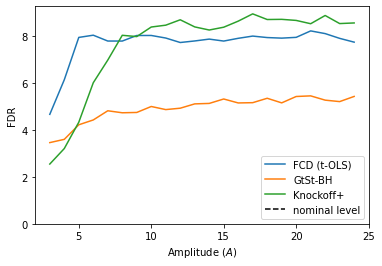

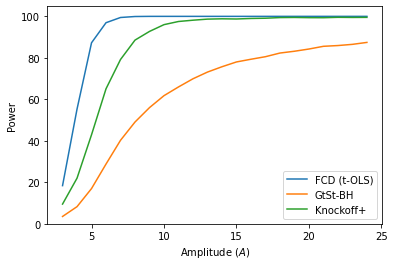

In [3]:
try:
    os.makedirs('figuresSimulated')
except:
    pass

plt.figure(1)
plt.plot(list_A, 100*FDR['FCD'], label='FCD (t-OLS)')
plt.plot(list_A, 100*FDR['GtSt-BH'], label='GtSt-BH')
plt.plot(list_A, 100*FDR['Knockoff'], label='Knockoff+')
plt.xlabel('Amplitude ($A$)')
plt.ylabel('FDR')
plt.ylim(bottom=0)
plt.hlines(10, min(list_A), max(list_A), colors='black', linestyle='--', label='nominal level')
plt.legend()
plt.savefig('figuresSimulated/amplitude_effect_fdr.png',dpi=300)

plt.figure(2)
plt.plot(list_A, 100*power['FCD'], label='FCD (t-OLS)')
plt.plot(list_A, 100*power['GtSt-BH'], label='GtSt-BH')
plt.plot(list_A, 100*power['Knockoff'], label='Knockoff+')
plt.xlabel('Amplitude ($A$)')
plt.ylabel('Power')
plt.ylim(bottom=0)
plt.legend()

plt.savefig('figuresSimulated/amplitude_effect_power.png',dpi=300)

### Ib. Effect of feature correlation

We test the effect of feature correlations. We set $n =200$, $p = 100$, $k = 20$, $A = 10$. Recall that the rows of the design matrix $X$ are generated from a $\mathcal N_p(0,\Sigma)$ distribution, with $\Sigma_{ij} = \eta^{|i-j|}$, and then the columns of $X$ are normalized to have unit norm. We vary the  parameter $\eta$ in the set $\{0.1, 0.15, 0.2, \dotsc, 0.75, 0.8, 0.85\}$. For each value of $\eta$, we compute FDR and power for both methods, by averaging over `nbite = 3000` realizations of noise and design matrix $X$.

In [5]:
# EFFECT CORRELATION
# We choose the parameters as in the paper
n, p, k, A = 200, 100, 20, 10
# in the paper nbite = 3000
nbite = 3000

list_eta = np.arange(0.1,0.85,0.05)

algos = ['FCD','Knockoff','GtSt-BH']

FDR = {name:np.zeros(len(list_eta)) for name in algos}
power = {name:np.zeros(len(list_eta)) for name in algos}

for i, eta in enumerate(list_eta):
    theta0, X, S, y = generate_data(n, p, k, eta, A)

    for _ in range(nbite):
        theta0, X, S, y = generate_data(n, p, k, eta, A)
        model = Testing()
        signhat, Shat = FCD(n, p, X, y)
        FDR['FCD'][i] += model.FDR(Shat, S) / nbite
        power['FCD'][i] += model.power(Shat, S) / nbite
        
        fdr, pow = model.fdr_power_lars(X,y,S,0.1)
        FDR['GtSt-BH'][i] += fdr / nbite
        power['GtSt-BH'][i] += pow / nbite

        fdr, pow = model.fdr_power_knockoffs(X,y,S,alpha=0.1,mode='equicorrelated',knockoff_plus=True)
        FDR['Knockoff'][i] += fdr / nbite
        power['Knockoff'][i] += pow / nbite

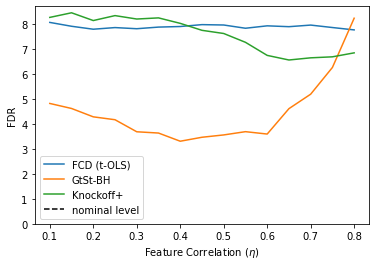

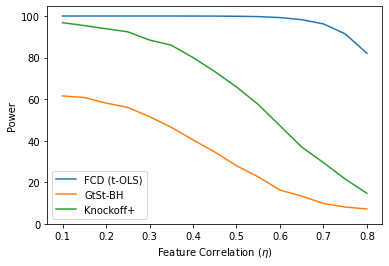

In [6]:
plt.figure(3)
plt.plot(list_eta, 100*FDR['FCD'], label='FCD (t-OLS)')
plt.plot(list_eta, 100*FDR['GtSt-BH'], label='GtSt-BH')
plt.plot(list_eta, 100*FDR['Knockoff'], label='Knockoff+')
plt.xlabel('Feature Correlation ($\eta$)')
plt.ylabel('FDR')
plt.ylim(bottom=0)
plt.hlines(10, min(list_eta), max(list_eta), colors='black', linestyle='--', label='nominal level')
plt.legend()

plt.savefig('figuresSimulated/corr_effect_fdr.png',dpi=300)

plt.figure(4)
plt.plot(list_eta, 100*power['FCD'], label='FCD (t-OLS)')
plt.plot(list_eta, 100*power['GtSt-BH'], label='GtSt-BH')
plt.plot(list_eta, 100*power['Knockoff'], label='Knockoff+')
plt.xlabel('Feature Correlation ($\eta$)')
plt.ylabel('Power')
plt.ylim(bottom=0)
plt.legend()

plt.savefig('figuresSimulated/corr_effect_power.png',dpi=300)

### Ic. Effect of sparsity

We set $n = 200$, $p = 100$, $A = 10$, $\eta = 0.1$ and vary the sparsity level of the coefficients in the set $k\in[35]$. For both methods, the power and FDR are computed by averaging over `nbite = 3000` trials of noise and the generation of coefficient vector $\beta^0$.

In [7]:
# EFFECT of SPARSITY
# We choose the parameters as in the paper
n, p, eta, A = 200, 100, 0.1, 10
# in the paper nbite = 3000
nbite = 3000

list_k = np.arange(10,40,1)

algos = ['FCD','Knockoff','GtSt-BH']

FDR = {name:np.zeros(len(list_k)) for name in algos}
power = {name:np.zeros(len(list_k)) for name in algos}

for i, k in enumerate(list_k):
    for _ in range(nbite):
        theta0, X, S, y = generate_data(n, p, k, eta, A)
        model = Testing()
        try:
            signhat, Shat = FCD(n, p, X, y)
            FDR['FCD'][i] += model.FDR(Shat, S) / nbite
            power['FCD'][i] += model.power(Shat, S) / nbite
        except:
            print("error FCD")
            pass
        
        try: 
            fdr, powe = model.fdr_power_lars(X,y,S,0.1)
            FDR['GtSt-BH'][i] += fdr / nbite
            power['GtSt-BH'][i] += powe / nbite
        except:
            print("error gtst")
            pass
        
        try:
            fdr, pow = model.fdr_power_knockoffs(X,y,S,alpha=0.1,mode='equicorrelated',knockoff_plus=True)
            FDR['Knockoff'][i] += fdr / nbite
            power['Knockoff'][i] += pow / nbite
        except:
            print("error Knockoff")
            pass

error gtst
error gtst


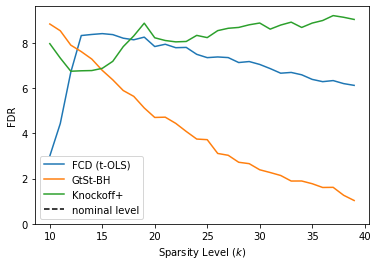

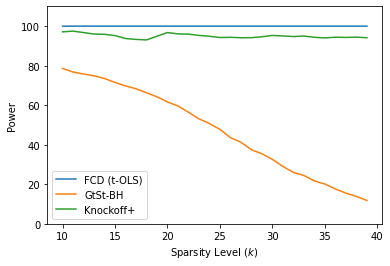

In [8]:
plt.figure(5)
plt.plot(list_k, 100*FDR['FCD'], label='FCD (t-OLS)')
plt.plot(list_k, 100*FDR['GtSt-BH'], label='GtSt-BH')
plt.plot(list_k, 100*FDR['Knockoff'], label='Knockoff+')
plt.xlabel('Sparsity Level ($k$)')
plt.ylabel('FDR')
plt.ylim(bottom=0)
plt.hlines(10, min(list_k), max(list_k), colors='black', linestyle='--', label='nominal level')
plt.legend()

plt.savefig('figuresSimulated/sparsity_effect_fdr.png',dpi=300)

plt.figure(6)
plt.plot(list_k, 100*power['FCD'], label='FCD (t-OLS)')
plt.plot(list_k, 100*power['GtSt-BH'], label='GtSt-BH')
plt.plot(list_k, 100*power['Knockoff'], label='Knockoff+')
plt.xlabel('Sparsity Level ($k$)')
plt.ylabel('Power')
plt.ylim(top=110)
plt.ylim(bottom=0)
plt.legend()

plt.savefig('figuresSimulated/sparsity_effect_power.png',dpi=300)

## II. Analysis of HIV dataset

The scientific goal is to determine which mutations of the Human Immunodeficiency Virus Type 1 (HIV-1) are associated with drug resistance. The data set, publicly available from the [Stanford HIV Drug Resistance Database](https://hivdb.stanford.edu/pages/published_analysis/genophenoPNAS2006/), was originally analyzed in (Rhee et al. 2006). The analysis described here is based on the article 
> *Multiple Testing and Variable Selection along Least Angle Regression's path*, [arXiv:1906.12072v3](https://arxiv.org/abs/1906.12072v3).

The dataset has been prepared as in 

> *Controlling the False Discovery Rate via Knockoffs*, [arXiv:1404.5609](https://arxiv.org/abs/1404.5609).

We present here the selected proatease positions that may present a resistance to APV.

In [9]:
!pip install pyreadr
import pyreadr

def get_data(name):
    '''
    Load HIV data. The fils have been created using the preprocessing presented in 
    https://cran.r-project.org/web/packages/knockoff/vignettes/hiv.html
    '''
    result = pyreadr.read_r('data/y'+name+'.RData')
    Y = result['y']
    y = np.array(Y).reshape(-1)
    X = pd.read_csv("data/X"+name+".csv", header=0,index_col=0)
    n,p = X.shape
    X = np.array(X).reshape(n,p)
    result = pyreadr.read_r('data/labels'+name+'.RData')
    labels = result['labels']
    labels = np.array(labels).reshape(-1)
    return y, X, labels

def stacked_bar(data, series_labels, category_labels=None,
					show_values=False, value_format="{}", y_label=None,
					grid=True, reverse=False):
		"""Plots a stacked bar chart with the data and labels provided.

		Keyword arguments:
		data			-- 2-dimensional numpy array or nested list
						   containing data for each series in rows
		series_labels   -- list of series labels (these appear in
						   the legend)
		category_labels -- list of category labels (these appear
						   on the x-axis)
		show_values	 -- If True then numeric value labels will 
						   be shown on each bar
		value_format	-- Format string for numeric value labels
						   (default is "{}")
		y_label		 -- Label for y-axis (str)
		grid			-- If True display grid
		reverse		 -- If True reverse the order that the
						   series are displayed (left-to-right
						   or right-to-left)
		"""

		ny = len(data[0])
		ind = list(range(ny))

		axes = []
		cum_size = np.zeros(ny)

		data = np.array(data)

		if reverse:
			data = np.flip(data, axis=1)
			category_labels = reversed(category_labels)

		for i, row_data in enumerate(data):
			axes.append(plt.bar(ind, row_data, bottom=cum_size,
								label=series_labels[i]))
			cum_size += row_data

		if category_labels:
			plt.xticks(ind, category_labels)

		if y_label:
			plt.ylabel(y_label)

		plt.legend()

		if grid:
			plt.grid()

		if show_values:
			for axis in axes:
				for bar in axis:
					w, h = bar.get_width(), bar.get_height()
					plt.text(bar.get_x() + w / 2, bar.get_y() + h / 2,
							 int(h), ha="center",
							 va="center")

Traceback (most recent call last):
  File "/Users/Yohann/opt/anaconda3/bin/pip", line 7, in <module>
    from pip._internal.cli.main import main
  File "/Users/Yohann/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/main.py", line 8, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/Users/Yohann/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/autocompletion.py", line 9, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/Users/Yohann/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/main_parser.py", line 7, in <module>
    from pip._internal.cli import cmdoptions
  File "/Users/Yohann/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/cmdoptions.py", line 22, in <module>
    from pip._internal.cli.progress_bars import BAR_TYPES
  File "/Users/Yohann/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/progress_bars.py", line 9, in <module>
    from pip._internal.utils.log

## III. Comparison of GtSt, FCD, Knockoff and Slope

The next lines give the result of the `methods = ['lars','KSDP', 'KEQUI','FCD','SLOPE']` for the HIV drug resistance dataset.

In [10]:
datasets = ['APV', 'NFV', 'IDV','ATV', 'LPV', 'RTV','SQV']
result = pyreadr.read_r('data/truelabels.RData')
true_vars = result['truelabels']
true_vars = np.array(true_vars).reshape(-1)
methods = ['lars','KSDP', 'KEQUI','FCD','SLOPE']
IN = [np.zeros(len(datasets)) for name in methods]
OUT = [np.zeros(len(datasets)) for name in methods]

import re
for i, namedata in enumerate(datasets):
    y, X, labels = get_data(namedata)
    # 
    support2var = ['' for i in labels]
    for j,name in enumerate(labels):
        support2var[j] = int(re.sub("[^0-9]", "", name))
    support2var = np.array(support2var)
    model = Testing()
    model.compute_lars_path(X, y, lars_algorithm='recursive', normalization=True)
    for k,algo in enumerate(methods):
        if algo=='FCD':
            n, p = X.shape 
            signhat, Shat = FCD(n, p, X, y, level=0.2)
            variables = support2var[Shat]
            outs = len(set(variables)-set(true_vars))
            ins = len(true_vars) - len(set(true_vars)-set(variables))
            IN[k][i] = ins
            OUT[k][i] = outs
        elif algo=='SLOPE':
            prediction = np.array(pd.read_csv("data/SLOPE/slopeHIV-"+namedata+".csv", header=0,index_col=0)).reshape(-1)
            prediction -= 1 # since R indexation starts at 1
            variables = support2var[prediction]
            outs = len(set(variables)-set(true_vars))
            ins = len(true_vars) - len(set(true_vars)-set(variables))
            IN[k][i] = ins
            OUT[k][i] = outs
        else:
            IN[k][i], OUT[k][i] = model.in_out_support(true_vars, support2var, X=X, y=y, alpha=0.2, method=algo, K1=101)

IN = np.array(IN)
OUT = np.array(OUT)
category_labels = ['GtSt-BH', 'Knockoff-SDP', 'Knockoff-Equi', 'FCD (t-OLS)', 'SLOPE']
series_labels = ['In TSM list', 'NOT in TSM list']

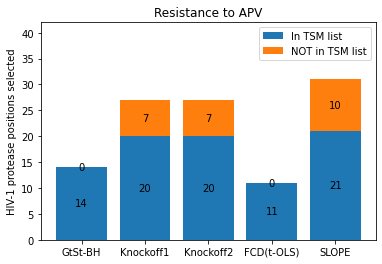

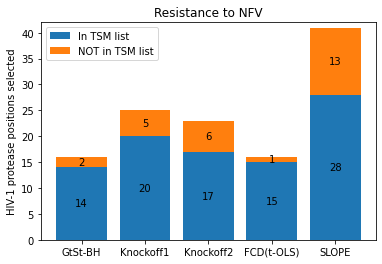

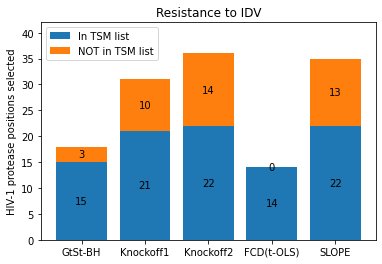

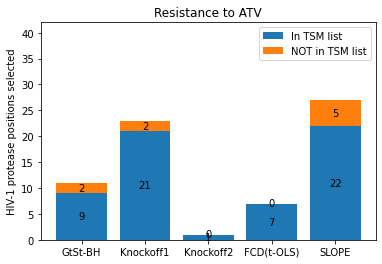

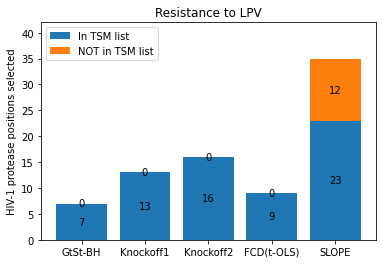

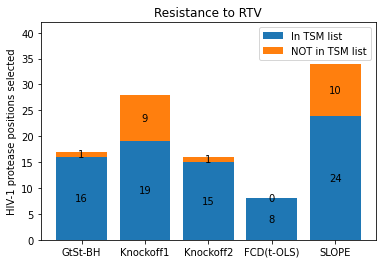

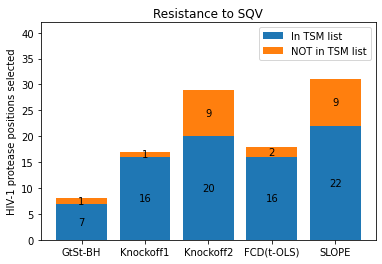

In [11]:
category_labels = ['GtSt-BH', 'Knockoff1', 'Knockoff2', 'FCD(t-OLS)', 'SLOPE']
series_labels = ['In TSM list', 'NOT in TSM list']
for i,namedata in enumerate(datasets):
    stacked_bar(np.array([IN[:,i],OUT[:,i]]), series_labels, category_labels=category_labels, show_values=True, value_format="{:d}",y_label="HIV-1 protease positions selected",grid=False,reverse=False)
    plt.ylim([0,42])
    plt.title('Resistance to '+namedata)
    plt.savefig('figuresHIV/'+namedata+'.png', dpi=300)
    plt.show()

## IV. LARS reccursive formulation

We load the **APV dataset**.

In [12]:
y, X, labels = get_data('APV')# You can try: 'NFV', 'IDV','ATV', 'LPV', 'RTV','SQV'

n,p = np.shape(X)
print("There is p=%s observations for %s predictors." %(n,p))

There is p=767 observations for 201 predictors.


We compute the LAR's path using the *recursive formulation* of the article:
> *Multiple Testing and Variable Selection along Least Angle Regression's path*, [arXiv:1906.12072v3](https://arxiv.org/abs/1906.12072v3).

In [13]:
from lars.multiple_spacing_tests import lar_rec

print("Computing the recursive formulation of LAR as in (Azaïs and De Castro, 2021)")

lambdas, indexes, correls, R, Z = lar_rec(X, y, normalization = True) #Algorithm 1 in (Azaïs and De Castro, 2019)

Computing the recursive formulation of LAR as in (Azaïs and De Castro, 2021)


In [14]:
from sklearn import linear_model

print("Computing regularization path using the LAR from scikit learn.")

alphas, active, coefs = linear_model.lars_path(X, 
                                               y, 
                                               Xy           = Z[range(p)], 
                                               Gram         = R[0:p,0:p], 
                                               max_iter     = p-1, 
                                               method       = 'lar', 
                                               eps          = 1e-23,
                                               verbose      = False, 
                                               return_path  = True)

lambdas_lar_scikit_learn = n*alphas
indexes_lar_scikit_learn = active

Computing regularization path using the LAR from scikit learn.


We then compare the two algorithms on the HIV dataset. They offer the same output except on the tail of the LAR's path where **`sklearn` gives abnormal values** (the sequence is no longer non-increasing as it should be).

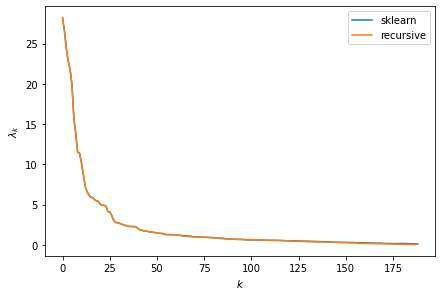

In [15]:
import matplotlib.pyplot as plt

k_max = min(np.size(indexes_lar_scikit_learn), np.size(indexes))

plt.plot(range(k_max-1),lambdas_lar_scikit_learn[:k_max-1])
plt.plot(range(k_max-1),lambdas[:k_max-1])
plt.legend([r'sklearn', r'recursive'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.show()

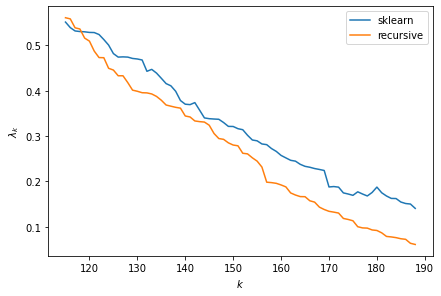

In [16]:
d = 75 #we focus on the last 75 values
plt.plot(range(k_max-d,k_max-1),lambdas_lar_scikit_learn[k_max-d:k_max-1])
plt.plot(range(k_max-d,k_max-1),lambdas[k_max-d:k_max-1])
plt.legend([r'sklearn', r'recursive'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.show()

In the above plot, `SciKitLearn` returns incresing values which is prohibited. The two algorithm retun the same values on the $50$ first knots of LAR.

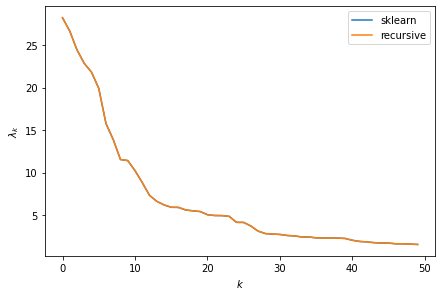

In [17]:
d = 50 #compare the 50 first knots
plt.plot(lambdas_lar_scikit_learn[0:d])
plt.plot(lambdas[0:d])
plt.legend([r'sklearn', r'recursive'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.show()

We can also compare the sequence of variables entering the model. Here again, they agree except on the tail of the LAR's path.

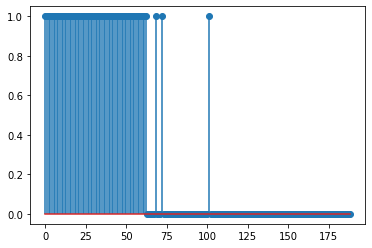

In [18]:
agree = 1*np.array(indexes[:k_max-1] == indexes_lar_scikit_learn[:k_max-1])
plt.stem(agree)
plt.show()

A deeper investigation shows that sklearn and the recuresive formulation differs at step $k=61$. Sklearn returns almost the same value $\lambda$ at step $k=61$ and $k=62$, and incoherent values (namely an increasing $\lambda$) at step $k=132$ (see below). We also computed the three others formualtions of the LAR (not showed here) and we found the same lambdas and indexes as in the recursive formulation presented here.

In [19]:
start = 61
end = 64
lambdas_lar_scikit_learn[start:end], lambdas[start:end], lambdas_lar_scikit_learn[132:134]

(array([1.21553574, 1.21498344, 1.17083938]),
 array([1.21553574, 1.18882636, 1.12469594]),
 array([0.44274209, 0.44699038]))

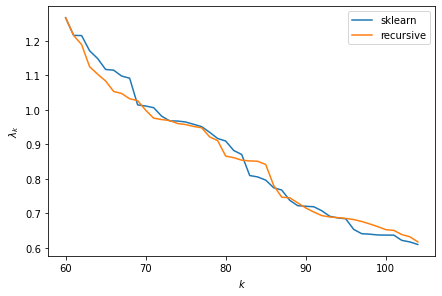

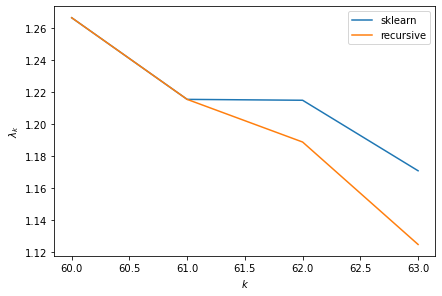

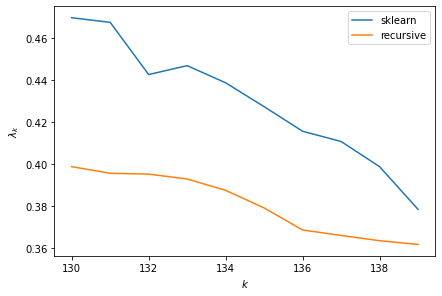

In [20]:
start = 60
end = 105
plt.plot(range(start,end),lambdas_lar_scikit_learn[start:end])
plt.plot(range(start, end),lambdas[start:end])
plt.legend([r'sklearn', r'recursive'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.show()

start = 60
end = 64
plt.plot(range(start,end),lambdas_lar_scikit_learn[start:end])
plt.plot(range(start, end),lambdas[start:end])
plt.legend([r'sklearn', r'recursive'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.show()

start = 130
end = 140
plt.plot(range(start,end),lambdas_lar_scikit_learn[start:end])
plt.plot(range(start, end),lambdas[start:end])
plt.legend([r'sklearn', r'recursive'])
plt.tight_layout()
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.show()